In [1]:
!pip install pmdarima

In [231]:
# Load libraries
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yfin
from fredapi import Fred
from ta import add_all_ta_features
from ta.utils import dropna
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from ipywidgets import interact
import ipywidgets as widgets
import plotly.express as px

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

In [234]:
#creating dates
start = datetime.date.today()-datetime.timedelta(365*5)
new_end = datetime.date.today()
end = datetime.date(2024, 12, 20)
covid_start = datetime.date(2020, 3, 1)
covid_end = datetime.date(2020, 12, 31)

In [237]:
#getting data to analyse
def get_data(startdate, enddate, tickers, inter = "1d"):
    data = yfin.download(list(tickers.keys()), startdate, enddate, interval = inter)
    data = data.rename(columns=tickers)
    data = data.dropna()
    data.index = data.index.tz_localize(None)
    return data
    
tickers_dict = {"au_usd":{"GC=F":"AU_USD"},"usd_zar":{"ZAR=X":"USD_ZAR"},
               "usd_jyp":{"JPY=X":"USD_JPY"},"aud_usd":{"AUDUSD=X":"AUD_USD"},
               "eur_usd":{"EURUSD=X":"EUR_USD"}, "apple":{"AAPL":"Apple"},
                "vanguard":{"VMBS":"Vanguard"},"ishares":{"MBB": "iShares"}}


In [239]:
# Removing trends from non-stationary time series
# This is done to ensure that the data is stationary before modelling
# Stationarity implies that data is homoskedastic - variance is constant
# Furthemore, the mean function is constant and independent of t

In [241]:
# First method to remove a trend from non-stationary data is to model variable with
# linear trend variable
# Running a simple regression model for selected dataset
au_usd = get_data(start, end, tickers_dict["au_usd"])
au_reg = np.linspace(1, len(au_usd.Close), len(au_usd.Close)) # creating array of 
#evenly spaced numbers from 1 to the length of au_usd
au_reg = sm.add_constant(au_reg) # adds column of 1's next to column of above linspace

# Fitting the ordinary least squares regression model
au_usd_mod = sm.OLS(au_usd.Close, au_reg)
fit_au_usd = au_usd_mod.fit()
fit_au_usd.summary()



[*********************100%***********************]  1 of 1 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AU_USD   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     1561.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):          4.10e-221
Time:                        17:12:23   Log-Likelihood:                -8093.5
No. Observations:                1232   AIC:                         1.619e+04
Df Residuals:                    1230   BIC:                         1.620e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1605.8442      9.844    163.133      0.000    1586.532    1625.157
x1             0.5465      0.014     39.512      0.000       0.519       0.574
==============================================================================
Omnibus:                       53.571   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.006
Skew:                           0.540   Prob(JB):                     9.33e-14
Kurtosis:                       2.976   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

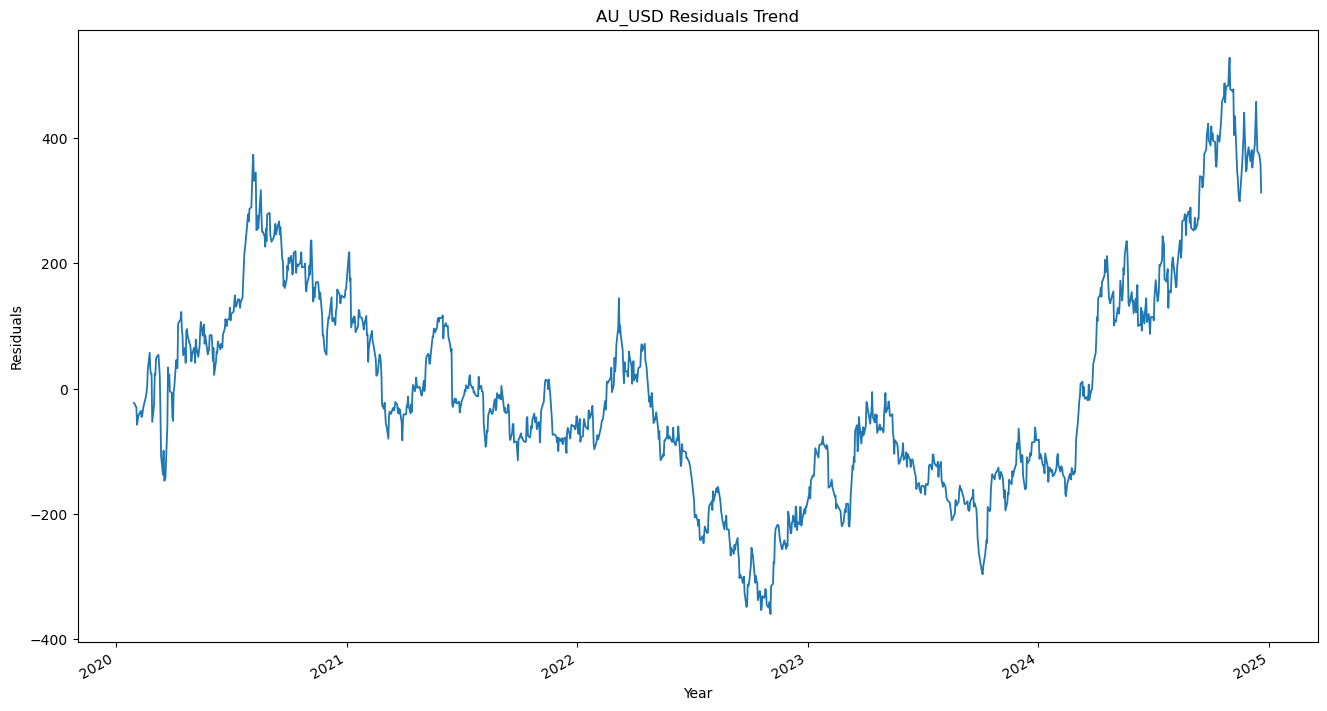

In [243]:
# Plotting residuals from model againt time
au_usd_res = fit_au_usd.resid
au_usd_res.plot(linewidth=1.3, xlabel="Year", ylabel="Residuals", title = "AU_USD Residuals Trend")
plt.show()

V-shape obtained when plotting residuals, therefore mean is not constant over time.
Next step is to use differencing method

In [246]:
# getting variable name
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name




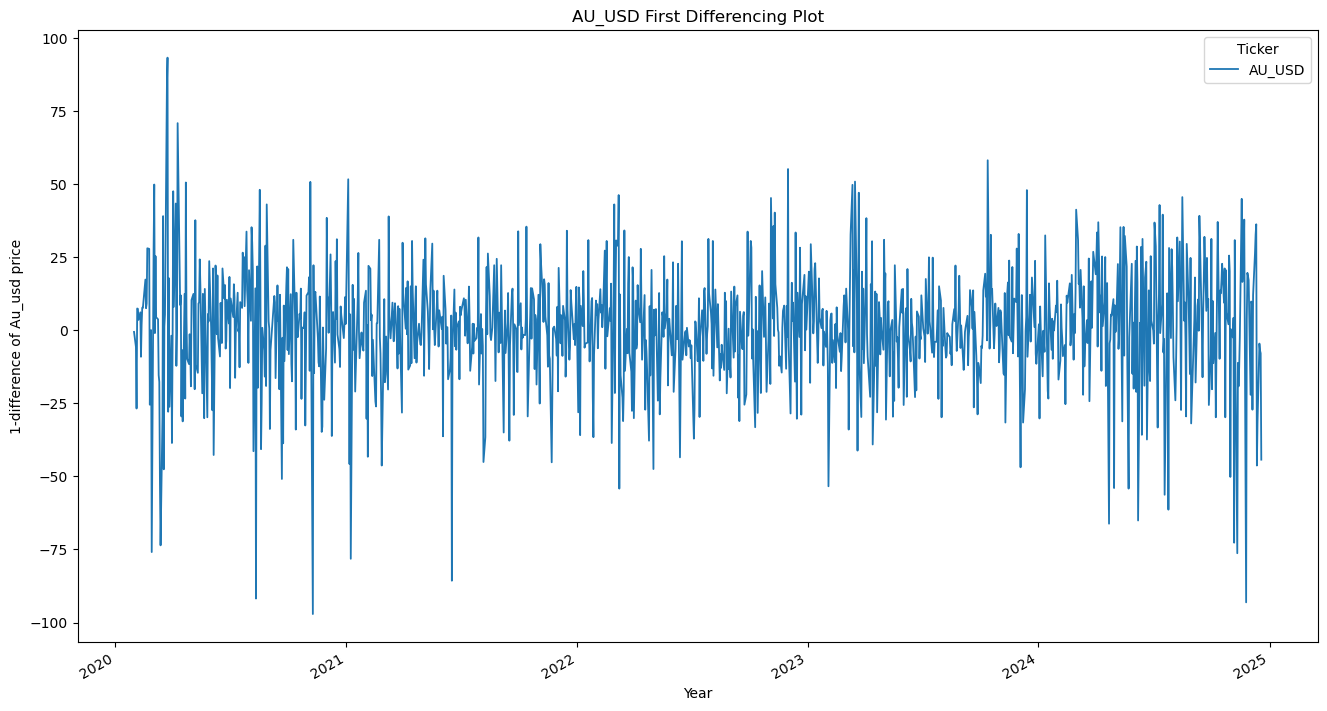

In [248]:
# Plotting First Difference of selected data
def plot_diff(df,param,order:1):
    df[param].diff(order).plot(
    linewidth=1.3, xlabel="Year", 
        ylabel=f"{order}-difference of {get_var_name(df).capitalize()} price",
        title = "AU_USD First Differencing Plot")
    return plt.show()
plot_diff(au_usd,"Close",1)

First difference for au_usd is relatively stable about 0
Next step is to plot autocorrelation function (ACF) of first difference for au_usd

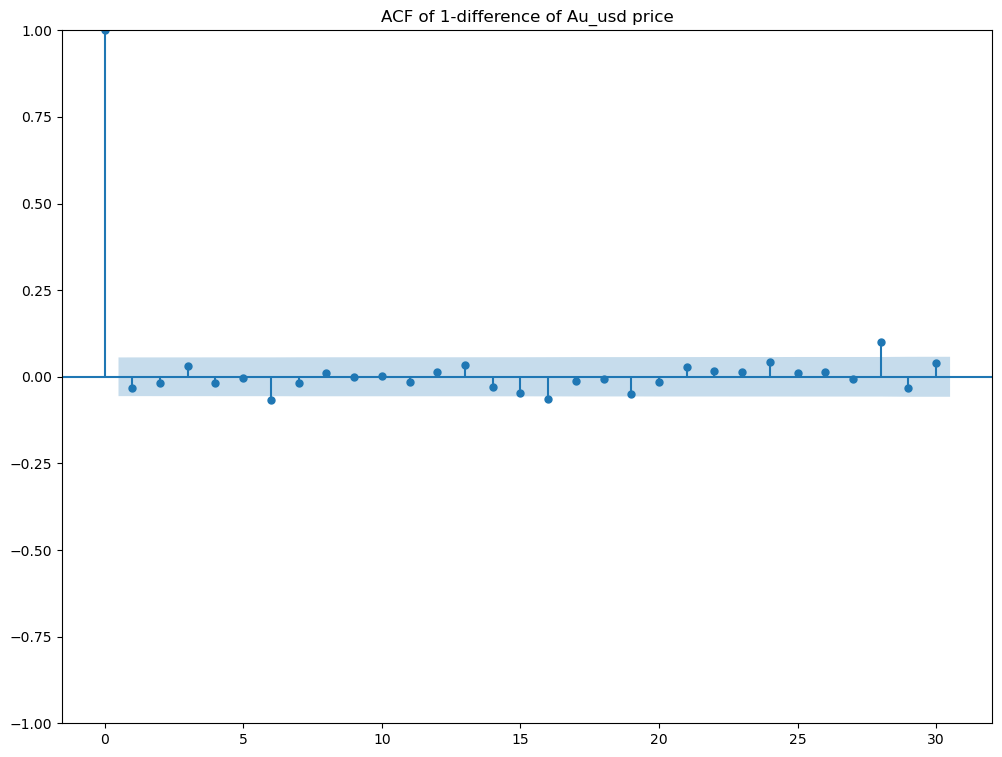

In [251]:
# ACF of First Difference of Google Stock Price
# (Note: [1:] as we need to skip first element since the model lost one data point)
def diff_acf_plot(df,param,order:1,lag):
    fig, ax = plt.subplots(figsize=(12, 9))
    sm.graphics.tsa.plot_acf(df[param].diff(order)[1:],
        title=f"ACF of {order}-difference of {get_var_name(df).capitalize()} price",
        lags=lag,
        ax=ax,)
    return plt.show()

diff_acf_plot(au_usd,"Close",1,30)

Only lag 28 is significant at the 95% level.
First difference seems to be enough to remove trend in the au_usd data.
Next step is to use first diff to model au_usd

In [254]:
# Using ARIMA model to model first diff of selected data 
au_usd_diff1 = statsmodels.tsa.arima.model.ARIMA(au_usd.Close, order=(0, 1, 0)).fit()
print(au_usd_diff1.params)

sigma2    394.99478
dtype: float64


/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


sigma2    394.99478
dtype: float64


/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


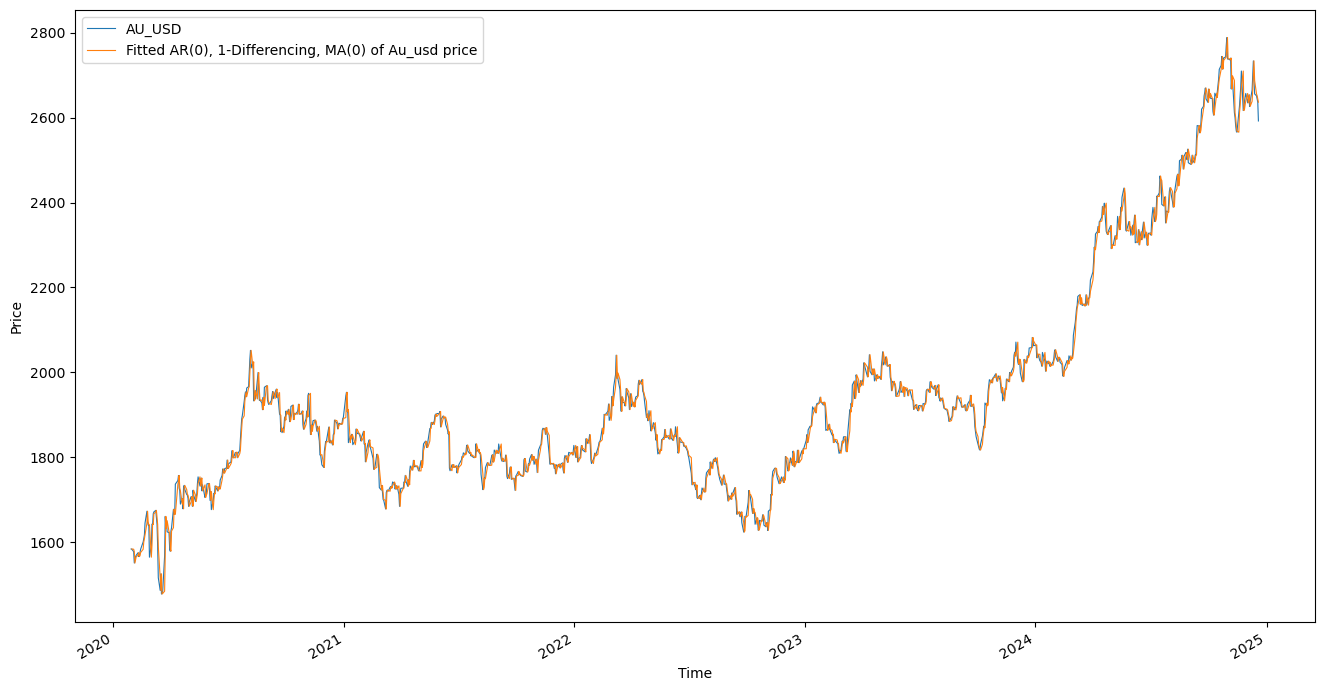

In [256]:
# Plotting original data vs modelled data

def og_vs_mod(df,param,x,y,z):
    """df - the dataframe of interest
    param - is the parameter in the dataframe to be analysed as str - eg close price, open price etc
    x - AR order , y = differencing order, z = MA order"""
    diff1 = statsmodels.tsa.arima.model.ARIMA(df[param], order=(x,y,z)).fit()
    diff1_res = diff1.resid # determining residuals from first diff model
    diff1_fit = df[param].squeeze() - diff1_res # creating model data from subtracting residuals from originals
    
    diff1_res = diff1_res[1:]  # need to skip first element since the model lost one data point
    diff1_fit = diff1_fit[1:]  # need to skip first element since the model lost one data point
    
    df[param].plot(linewidth=0.8, label=f"Original {get_var_name(df).capitalize()} price")
    diff1_fit.plot(linewidth=0.8, label=f"Fitted AR({x}), {y}-Differencing, MA({z}) of {get_var_name(df).capitalize()} price"
    )
    print(diff1.params)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    
    return plt.show()

og_vs_mod(au_usd,"Close",0,1,0)

In [258]:
# Efficient ARIMA model Selection
def choose_best_mod(df,param):
    
    mod_can_auto = auto_arima(
        df[param],  # stepwise=False,
        start_p=0,
        start_d=0,
        start_q=0,
        max_p=3,
        max_d=3,
        max_q=3,
        trace=True,
        with_intercept=False,
        return_valid_fits=True,)
    return mod_can_auto


In [260]:
# Best ARIMA Model for selected data price
# (0,1,0) for AU_USD
def use_best_mod(df, param,x,y,z):
    
    final_mod = SARIMAX(
        df[param], order=(x,y,z), trend="c").fit()  # This is the best model in Python implementation
    print(final_mod.summary())
    return final_mod

In [262]:
# Forecasting using best predicted plot with 95% and 80% Confidence Interval

# Plot Google data
def forecasting(df,param,step, x,y,z):
    """Returns forecast fro parameter using best provided ARIMA model for 80% and 95% confidence intervals

    df - dataframe of interest
    param - is the parameter in the dataframe to be analysed as str - eg close price, open price etc
    x - AR order , y = differencing order, z = MA order
    step - number of days in future to predict"""
    #og_vs_mod(df,param,x,y,z)

    new = df[param].copy()
    new.index = [i for i in range(len(new))]  # Set numeric index
    new.plot(ylabel=f"{get_var_name(df).capitalize()} Price", title=f"Forecast from ARIMA({x},{y},{z})", color="k")
    
    # get forecast data for next steps
    forecast = use_best_mod(df,param, x,y,z).get_forecast(steps=step)
    forecast_mean = forecast.predicted_mean  # mean of forecast data
    conf_int95 = forecast.conf_int(alpha=0.05)  # 95% confidence interval
    conf_int80 = forecast.conf_int(alpha=0.2)  # 80% confidence interval
    
    # plot mean forecast and 95% and 80% confidence intervals
    x = []
    for v in range(1,len(forecast_mean)+1):
        x.append(len(new)+v)
        
    plt.plot(x,forecast_mean, c="b")
    plt.fill_between(x,conf_int95[f"lower {get_var_name(df).upper()}"],
                     conf_int95[f"upper {get_var_name(df).upper()}"],color="b",alpha=0.3,)
    
    plt.fill_between(x,conf_int80[f"lower {get_var_name(df).upper()}"],
                     conf_int80[f"upper {get_var_name(df).upper()}"],color="b",alpha=0.5,)
    plt.grid()
    
    return plt.show()




In [264]:
def get_days(startdate,enddate):
   
    delta = enddate - startdate
    return delta.days

get_days(end, new_end)

39

In [273]:
# Forecast only function for all confidence levels
# Forecasting using best predicted plot at desired Confidence Intervals

# Plot Google data
def forecast_only(name,param, order_list, conf_list, dates_list, inter = "1d"):
    """Returns forecast for parameter using best provided ARIMA model for specified confidence intervals

    name - security/comodity/currency pair of interest - str eg "au_usd", "apple", "usd_zar"
    param - is the parameter in the dataframe to be analysed as str - eg close price, open price etc
    order list entry 1 - AR order , order list entry 2 = differencing order, order list entry 3 = MA order, all 3 required
    conf_list - list of confidence intervals to be used in the plot - eg 95, 80, 60
    dates_list - list of 3 dates as tuple ie (2025,1,5) for 5 January 2025:
        date 1 = first date for model calibration
        date 2 = last date for model calibration
        date 3 = last date of actual data comparison (preferably set to latest data date)
        date 4 = final data for prediction
    inter - data frequency from yfinance - eg "1d" for daily data, "1h" for hourly data"""

    df = get_data(datetime.date(*dates_list[0]), datetime.date(*dates_list[1]), tickers_dict[name])

    # get forecast data for next steps
    forecast = use_best_mod(df,param, order_list[0],order_list[1],order_list[2]).get_forecast(\
        steps=get_days(datetime.date(*dates_list[1]),datetime.date(*dates_list[3])))
    forecast_mean = forecast.predicted_mean  # mean of forecast data
    #print(len(forecast_mean))
    # for loop to iterate through confidence levels list and obtain confidence interval data = 
    actual_data = get_data(datetime.date(*dates_list[1]), datetime.date(*dates_list[2]),tickers_dict[name])
    
    for t in conf_list:
        b = (100 - t)/100
        conf_int = forecast.conf_int(alpha=b) 

        # join confidence interval data with the forecast mean for each confidence level iteration
        forecast_data = conf_int.join([forecast_mean])
        # # for loop to create list of dates after final data point of training dataset
        x = []
        for v in range(1,len(forecast_mean)+1):
            c = df.index[-1].to_pydatetime()+datetime.timedelta(v)
            x.append(c)
        forecast_data.index =  x
        
        # create dataframe joining the forecast per condifence interval and the actual data 
        final = pd.concat([forecast_data, actual_data], axis=1).dropna()
        extra = forecast_data.iloc[get_days(datetime.date(*dates_list[1]), datetime.date(*dates_list[2])):]
        final_df = pd.concat([final, extra], axis=0)
        
    
        #plot confidence data for each confidence level
        plt.plot(final_df.index,final_df[final_df.keys()[2]], c="b")  
        plt.fill_between(final_df.index,final_df[final_df.keys()[0]],
                         final_df[final_df.keys()[1]],color="b",alpha=(b+1)/4)

    # plot the predicted forecast mean
    plt.plot(final_df.index,final_df[final_df.keys()[2]], c="b",  label = "Prediction")

    # plot the actual data for the predicted timeframe, i.e., Close price as well as Highest and Lowest prices in day
    plt.plot(final_df.index, final_df[final_df.keys()[3]], c = "darkgreen", label = "Actual Price")
    plt.plot(final_df.index, final_df[final_df.keys()[4]], c = "red", ls = "--", label = "Upper Actual")
    plt.plot(final_df.index, final_df[final_df.keys()[5]], c = "red",ls = "-",  label = "Lower Actual")
    plt.xticks(rotation = 45)
    plt.grid()
    plt.grid(True, "both")
    plt.xlabel("Time", fontsize = 14, fontweight = "bold")
    plt.ylabel("Price", fontsize = 14, fontweight = "bold")
    plt.title(f"{name.upper()} Forecast", fontsize = 18, fontweight = "bold")
    plt.legend()
    
    return plt.show()


In [276]:
choose_best_mod(au_usd,"Close")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10855.414, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10856.298, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10856.260, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10858.146, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10855.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10856.063, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10856.013, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10857.851, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.281 seconds


(ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
       with_intercept=False))

[*********************100%***********************]  1 of 1 completed
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Applications/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53566D+00    |proj g|=  1.87406D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   1.874D-08   4.536D+00
  F =   4.5356571519927487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                 AU_USD   No. Observations:                  258
Model:               SARIMAX(0, 1, 0

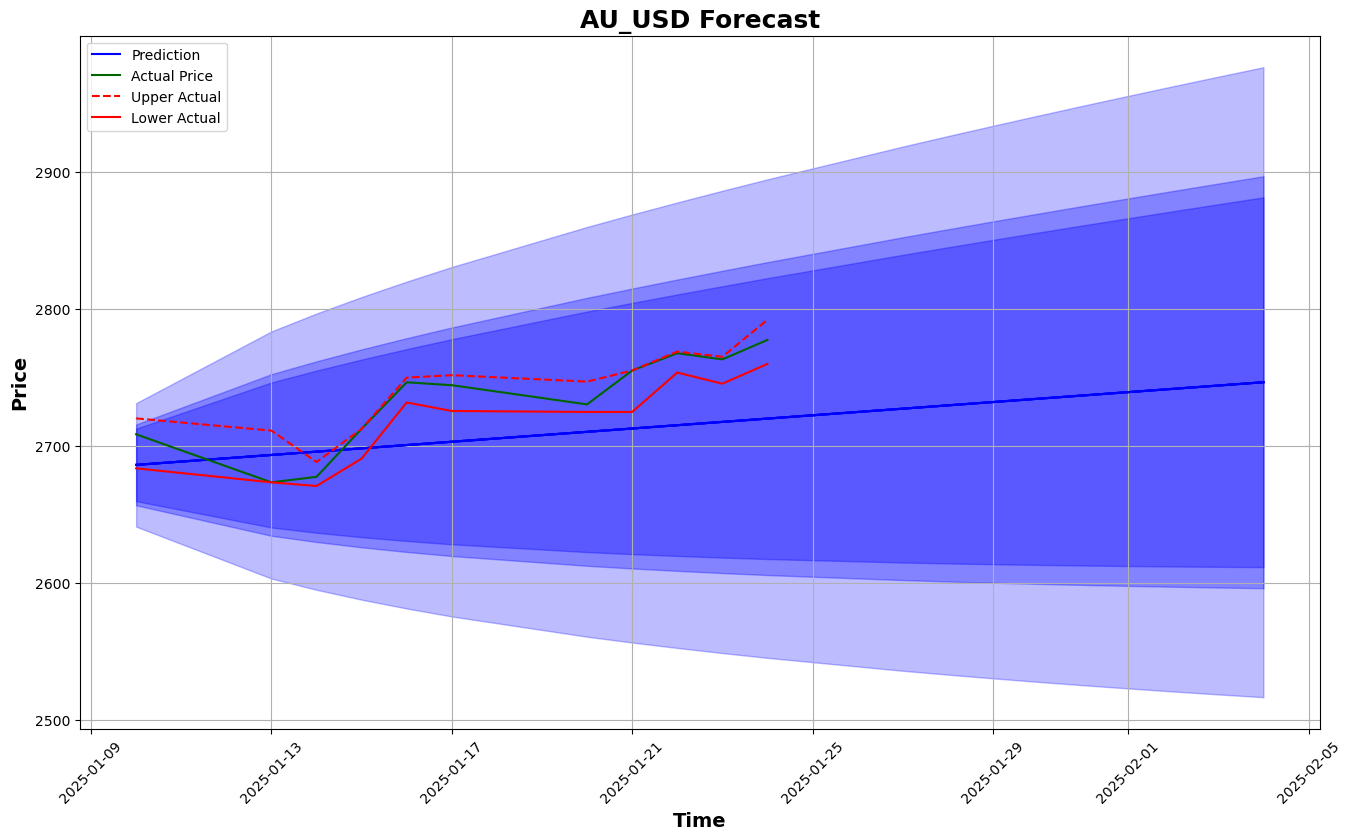

In [278]:
forecast_only("au_usd","Close",[0,1,0], [95,80,75], [(2024,1,1), (2025,1,10),(2025,1,27),(2025,2,5)])